# <center>CITS5017 Project 2<center>
<center>Allison Lau (23123849)<center>

# Import packages

In [38]:
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

# Load and Prepare Data
- `PerthA_df`: temperature data from 1944-06 to 2024-08 (total 963 months)
- `PerthM_df`: temperature data from 1994-01 to 2024-08 (total 368 months)

In [39]:
# load the data from the pickle file
def load_data(picklefile):
    f = open(picklefile, "rb")
    dict = pickle.load(f)
    f.close()
    return dict["Perth_Airport"], dict["Perth_Metro"]

# split the data into inputs and targets
def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
    # an inner function to do the splitting
    def split_inputs_and_targets(tf_ds):
        return tf_ds[:, :-targets_length], tf_ds[:, -targets_length:]

    if batch_size == -1:
        batch_size = df.shape[0]

    return tf.keras.utils.timeseries_dataset_from_array(
                tf.convert_to_tensor(df, dtype=tf.float32),
                targets = None,
                sequence_length = inputs_length + targets_length,
                batch_size = batch_size,
                shuffle = shuffle,
                seed = seed
            ).map(split_inputs_and_targets)

# Load data and display length
PerthA_df, PerthM_df = load_data("temperatures.pkl")
print(f"Total Perth Airport data: {len(PerthA_df)}")
print(f"Total Perth Metro data: {len(PerthM_df)}")

Total Perth Airport data: 963
Total Perth Metro data: 368


# Part 1 Tasks
Implement three algorithms for predicting the minimum and maximum temperatures and compare their performances.

## (a) Get training, validation, and test datasets

In [40]:
# Split data depending on the length of the sequences
def split_data_length(df, seq_lengths, train=False):
    inputs_length, targets_length = (seq_lengths)
    if train:
        ds = split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True)
    else:
        ds = split_data(df, inputs_length, targets_length, batch_size=-1, shuffle=False)
    return ds

# Separate into validation and test datasets
PerthM_val = PerthM_df.loc["1994-01":"2013-12"] # First 20 years
PerthM_test = PerthM_df.loc["2014-01":]         # Last 10 years

# Split into training, validation and test datasets
train_ds = split_data_length(PerthA_df, (72, 12), train=True)
val_ds = split_data_length(PerthM_val, (72, 12))
test_ds = split_data_length(PerthM_test, (72, 12))

for batch in test_ds.take(1):
    X_test, y_test = batch

## (b) `display_temperatures` function

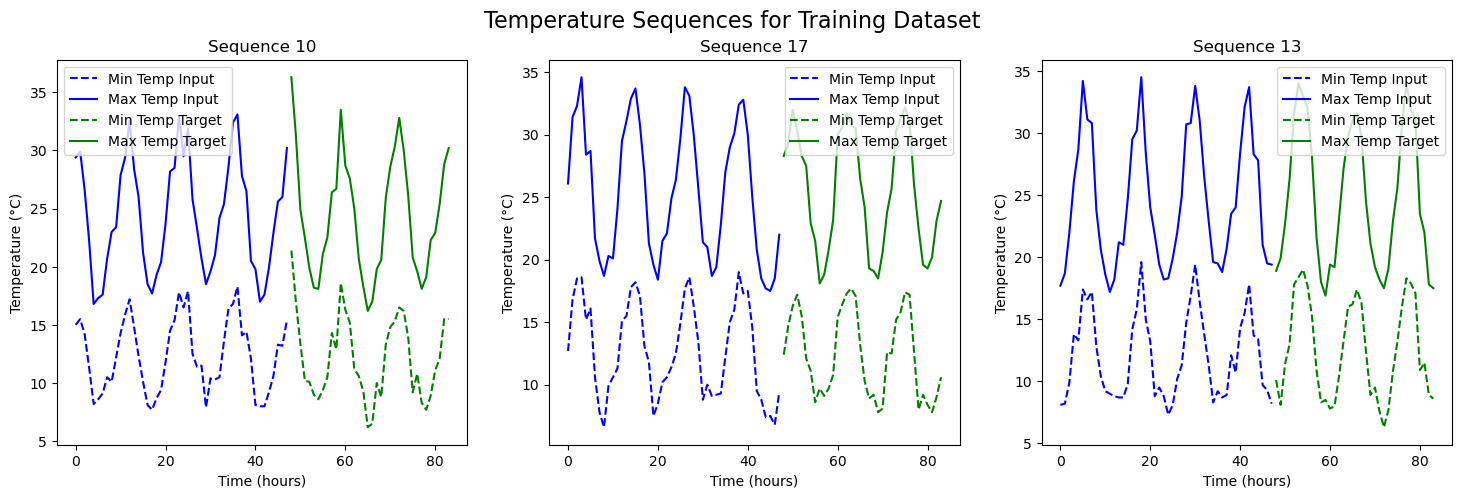

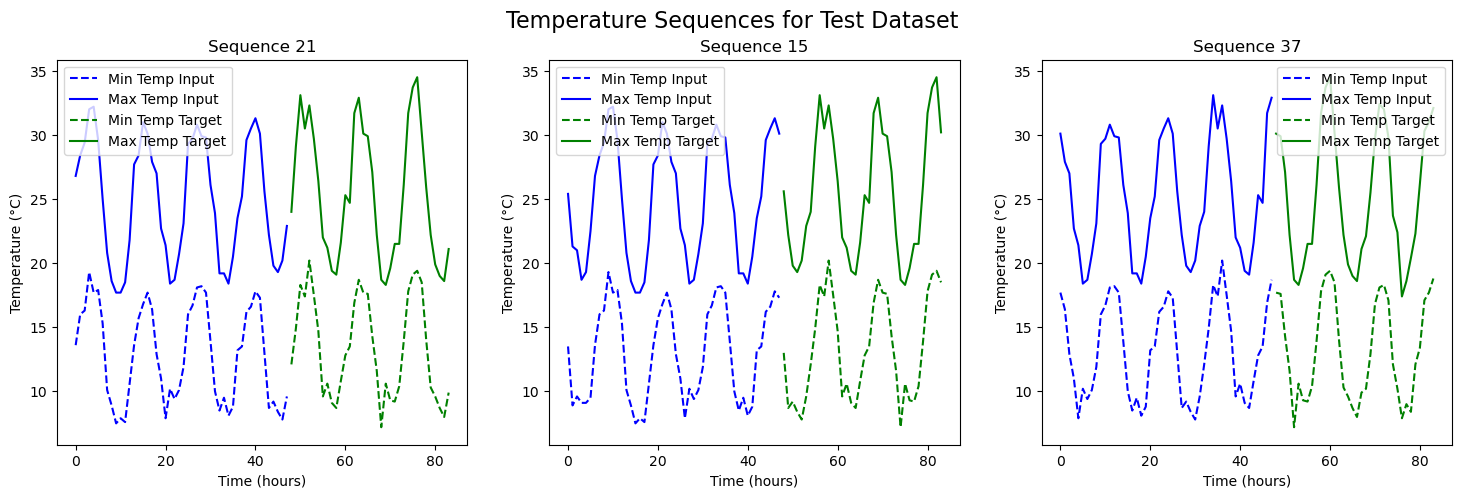

In [90]:
# Function to display 3 samples of temperature sequences (max and min)
def display_temperatures(input, target, indices, pred=None, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Temperature Sequences for {title}', fontsize=16)

    for i, idx in enumerate(indices):
        input_length = input.shape[1]
        target_length = target.shape[1]
        input_range = range(0, input_length)
        target_range = range(input_length, input_length+target_length)
        # min temp sequence in column 0, max temp sequence in column 1
        input_min = input[idx, :, 0]
        input_max = input[idx, :, 1]
        target_min = target[idx, :, 0]
        target_max = target[idx, :, 1]
        axes[i].plot(input_range, input_min, label="Min Temp Input", color='blue', linestyle='--')
        axes[i].plot(input_range, input_max, label="Max Temp Input", color='blue', linestyle='-')
        axes[i].plot(target_range, target_min, label="Min Temp Target", color='green', linestyle='--')
        axes[i].plot(target_range, target_max, label="Max Temp Target", color='green', linestyle='-')
        
        if pred is not None:
            pred_min = pred[idx, :, 0]
            pred_max = pred[idx, :, 1]
            axes[i].plot(target_range, pred_min, label="Min Temp Prediction", color='red', linestyle='--')
            axes[i].plot(target_range, pred_max, label="Max Temp Prediction", color='red', linestyle='-')
        
        axes[i].set_title(f"Sequence {idx}")
        axes[i].set_xlabel("Time (hours)")
        axes[i].set_ylabel("Temperature (°C)")
        axes[i].legend()

# Display 3 random sequences from the training dataset
for batch in train_ds.take(1):
    X_train, y_train = batch
    train_indices = random.sample(range(X_train.shape[0]), 3)
    display_temperatures(X_train, y_train, train_indices, title="Training Dataset")

# Display 3 random sequences from the test dataset
test_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, test_indices, title="Test Dataset")

## (c) Model 1

### Train Model 1

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_88 (GRU)                    │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_89 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 12, 2)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000 (11.72 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

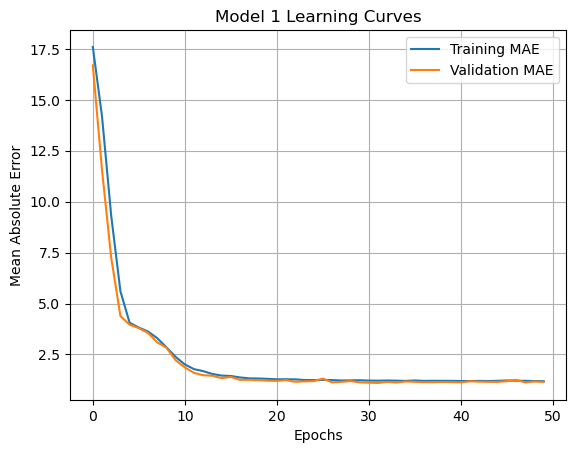

In [42]:
# Model 1: GRU with 2 layers of 16 units each
# Input shape: (72, 2) -> Output shape: (12, 2)
def create_model1(input_shape=(72, 2), output_shape=(12, 2)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(16, activation='relu', return_sequences=True),
        layers.GRU(16, activation='relu'),
        layers.Dense(output_shape[0] * output_shape[1]),
        layers.Reshape(output_shape)
    ])
    return model

# Function to train the model
def train_model(model, train_ds, val_ds, epochs=50, verbose=0):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=verbose)
    return history

# Function to plot the learning curves
def plot_learning_curves(history, title):
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{title} Learning Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid()
    plt.show()

# Create and display model 1
model1 = create_model1(input_shape=(72, 2))
model1.summary()

# Train model 1 and plot learning curves
history1 = train_model(model1, train_ds, val_ds)
plot_learning_curves(history1, "Model 1")

### Evaluate Model 1

Model 1 Test MAE: 1.35


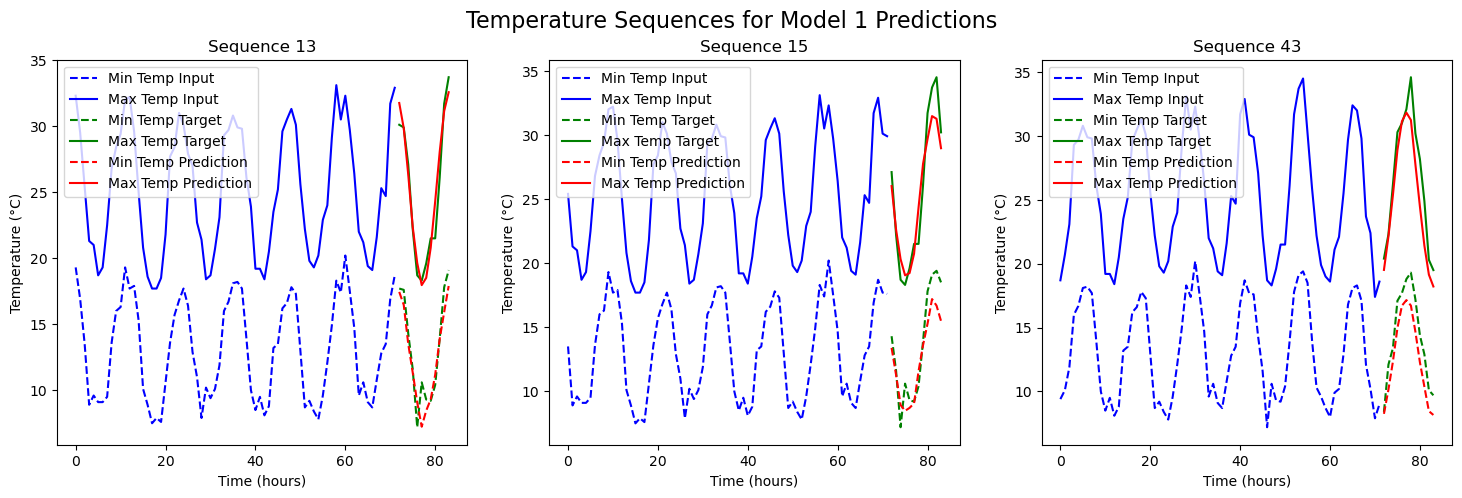

In [43]:
# Function to evaluate the model on the test dataset
def evaluate_model1(model, test_ds):
    _, test_mae = model.evaluate(test_ds, verbose=0)
    print(f"Model 1 Test MAE: {test_mae:.2f}")
    return test_mae

# Evaluate model 1 on the test dataset
y_pred = model1.predict(X_test, verbose=0)
mae1 = evaluate_model1(model1, test_ds)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 1 Predictions")

## (d) Model 2

### Train Model 2

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_90 (GRU)                    │ (None, 72, 16)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_91 (GRU)                    │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            34 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 2)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626 (10.26 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

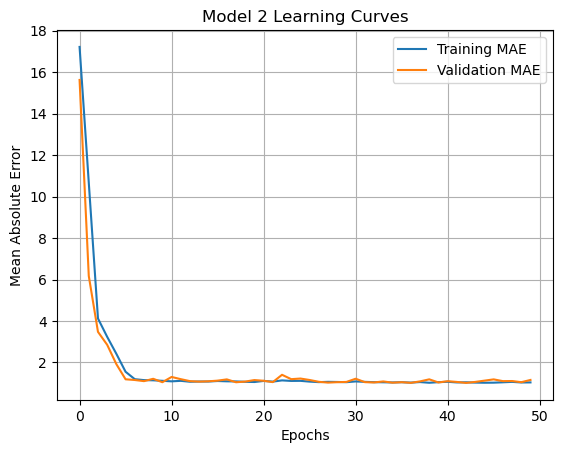

In [44]:
# Model 2: GRU with 2 layers of 16 units each
# Input shape: (72, 2) -> Output shape: (1, 2)
def create_model2(input_shape=(72, 2), output_shape=(1, 2)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(16, activation='relu', return_sequences=True),
        layers.GRU(16, activation='relu'),
        layers.Dense(output_shape[0] * output_shape[1]),
        layers.Reshape(output_shape)
    ])
    return model

# Split data for model 2 (output shape 1)
train_ds_output1 = split_data_length(PerthA_df, (72, 1), train=True)
val_ds_output1 = split_data_length(PerthM_val, (72, 1))

# Create and display model 2
model2 = create_model2()
model2.summary()

# Train model 2 and plot learning curves
history2 = train_model(model2, train_ds_output1, val_ds_output1, verbose=0)
plot_learning_curves(history2, "Model 2")

### Evaluate Model 2

Model 2 Test MAE: 1.50


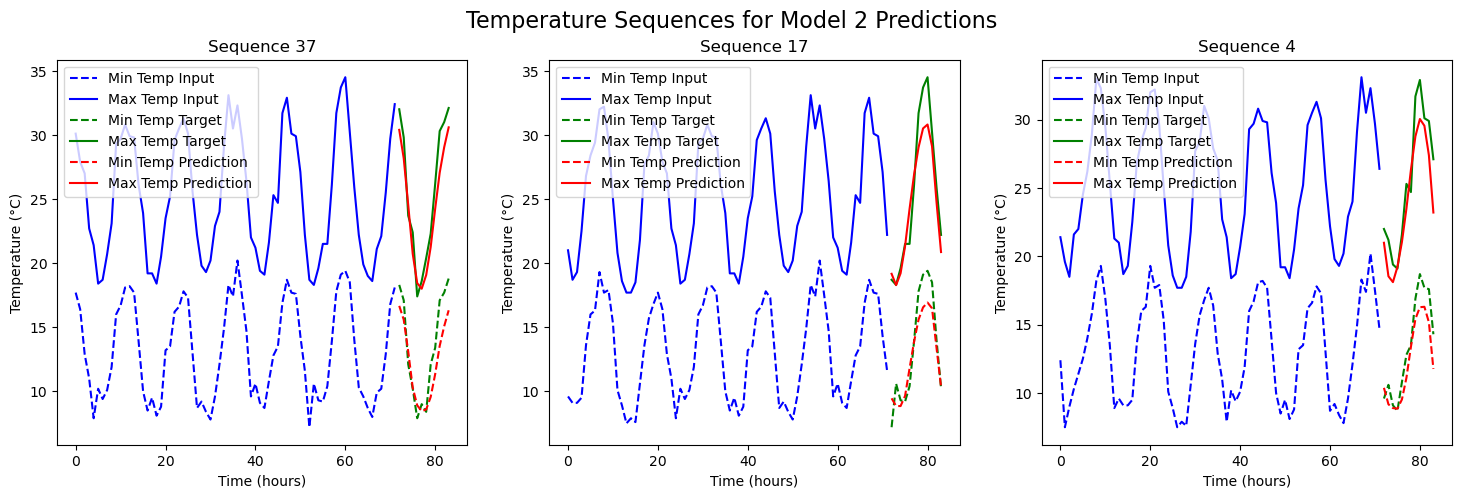

In [45]:
# Function to predict by months ahead
def predict_months(model, input_X, steps=12):
    X = input_X
    for step in range(steps):
        y_pred_one = model.predict(X[:, step:], verbose=0)
        X = np.concatenate([X, y_pred_one], axis=1)
    y_pred = X[:, -steps:, :]
    return np.array(y_pred)

# Function to evaluate the model 2 on the test dataset
def evaluate_model2(y_test, y_pred):
    # Calculate the MAE
    test_mae = tf.keras.losses.MAE(y_test, y_pred).numpy()
    test_mae = tf.reduce_mean(test_mae).numpy()
    print(f"Model 2 Test MAE: {test_mae:.2f}")
    return test_mae
    
# Evaluate model 2 on the test dataset
y_pred = predict_months(model2, X_test)
mae2 = evaluate_model2(y_test, y_pred)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (e) Model 3

### Train Model 3

In [ ]:
# Model 3: GRU Encoder-Decoder 
def create_model3(input_shape, output_shape):
    # Encoder
    encoder_inputs = layers.Input(shape=input_shape)
    encoder_gru1 = layers.GRU(16, activation='relu', return_state=True, return_sequences=True)
    encoder_gru2 = layers.GRU(16, activation='relu', return_state=True)
    encoder_outputs, encoder_state1 = encoder_gru1(encoder_inputs)
    encoder_outputs, encoder_state2 = encoder_gru2(encoder_outputs)
    
    # Decoder
    decoder_inputs = layers.Input(shape=output_shape)
    decoder_gru1 = layers.GRU(16, activation='relu', return_sequences=True, return_state=True)
    decoder_gru2 = layers.GRU(16, activation='relu', return_sequences=True, return_state=True)
    decoder_outputs, _ = decoder_gru1(decoder_inputs, initial_state=encoder_state1)
    decoder_outputs, _ = decoder_gru2(decoder_outputs, initial_state=encoder_state2)
    
    # Output
    decoder_dense = layers.Dense(2)
    decoder_outputs = decoder_dense(decoder_outputs)
    
    # Model
    model = models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

# Create and display model 3
model3 = create_model3(input_shape=(72, 2), output_shape=(12, 2))
model3.summary()

# Example of getting a batch from your validation dataset
for batch in val_ds.take(1):
    X_valid, y_valid = batch
    print(X_valid[:,:-1,:].shape, X_valid[:,-1,:].shape)
    X_valid_decode = y_valid[:, :-1, :]  # Exclude last timestep for decoding input
    y_valid_target = y_valid[:, 1:, :]  # Use shifted target for training

# Example of getting a batch from your training dataset
for batch in train_ds.take(1):
    X_train, y_train = batch
    X_train_decode = y_train[:, :-1, :]  # Exclude last timestep for decoding input
    y_train_target = y_train[:, 1:, :]  # Use shifted target for training
    
# Train model 3 and plot learning curves
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model3.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
history3 = model3.fit([X_train, X_train_decode], y_train_target, epochs=50, 
                      validation_data=([X_valid, X_valid_decode], y_valid_target), verbose=1)
plot_learning_curves(history3, "Model 3")

### Evaluate Model 3

In [ ]:
def predict(model, encoder_inputs, decoder_input, outseq_len):
    batch_size = encoder_inputs.shape[0]
    out_dim = decoder_input.shape[-1]
    outseq = np.zeros((batch_size, outseq_len, out_dim))
    decoder_ins = np.zeros((batch_size, outseq_len, out_dim))
    decoder_ins[:, 0, :] = decoder_input
    for t in range(outseq_len):
        pred = model.predict([encoder_inputs, decoder_ins], verbose=0)
        outseq[:, t, :] = pred[:, t, :]
        decoder_ins[:, t, :] = pred[:, t, :]
    return outseq

y_pred = predict(model3, X_test, y_test[:, 0:1, :], 12)

# Evaluate model 2 on the test dataset
y_pred = predict_months(model2, X_test)
mae2 = evaluate_model2(y_test, y_pred)

# Display 3 random sequences with predictions
sample_indices = random.sample(range(X_test.shape[0]), 3)
display_temperatures(X_test, y_test, sample_indices, y_pred, title="Model 2 Predictions")

## (f) Comparison of Models for different Target Lengths

### Train all models for different target lengths

In [54]:
settings = [(72, 12), (66, 18), (60, 24), (54, 30), (48, 36)]
model_maes = {
    'Model 1': [],
    'Model 2': [],
    'Model 3': []
}

for input_length, target_length in settings:
    # Prepare datasets for the current setting
    train_ds = split_data_length(PerthA_df, (input_length, target_length), train=True)
    val_ds = split_data_length(PerthM_val, (input_length, target_length))
    test_ds = split_data_length(PerthM_test, (input_length, target_length))
    train_ds2 = split_data_length(PerthA_df, (input_length, 1), train=True)
    val_ds2 = split_data_length(PerthM_val, (input_length, 1))

    print(f"\nSetting: ({input_length}, {target_length})")

    # Train and evaluate Model 1
    model_1 = create_model1((input_length, 2), (target_length, 2))
    train_model(model_1, train_ds, val_ds)
    mae_1 = evaluate_model1(model_1, test_ds)
    model_maes['Model 1'].append(mae_1)

    # Train and evaluate Model 2
    model_2 = create_model2((input_length, 2), (1, 2))
    train_model(model_2, train_ds2, val_ds2)
    for batch in test_ds.take(1):
        X_test, y_test = batch
        y_pred = predict_months(model2, X_test, steps=target_length)
    mae_2 = evaluate_model2(y_test, y_pred)
    model_maes['Model 2'].append(mae_2)

    # Train and evaluate Model 3
    # model_3 = create_model3()
    # TODO
    mae_3 = 0  # TODO
    model_maes['Model 3'].append(mae_3)


Setting: (72, 12)
Model 1 Test MAE: 1.21
Model 2 Test MAE: 1.50

Setting: (66, 18)
Model 1 Test MAE: 1.22
Model 2 Test MAE: 7.29

Setting: (60, 24)
Model 1 Test MAE: 1.16
Model 2 Test MAE: 1.82

Setting: (54, 30)
Model 1 Test MAE: 1.30
Model 2 Test MAE: 7.28

Setting: (48, 36)
Model 1 Test MAE: 1.22
Model 2 Test MAE: 2.42


### Plot MAE against target lengths for all models

In [ ]:
plt.figure(figsize=(10, 6))
for model, maes in model_maes.items():
    plt.plot([length[1] for length in settings], maes, marker='o', label=model)
plt.title('MAE vs Target Length for Different Models')
plt.xlabel('Target Length (Months)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xticks([length[1] for length in settings])
plt.legend()
plt.grid()
plt.show()

### Analysis

# Part 2 Tasks
Train a variational autoencoder (VAE) to synthesize temperature data.

## Train VAE model

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1821577856.0000 - mae: 10929.6602 - val_loss: 923.0255 - val_mae: 25.9180
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 944.8640 - mae: 25.3422 - val_loss: 248.7071 - val_mae: 23.8440
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 306.4990 - mae: 23.2793 - val_loss: 152.4071 - val_mae: 21.5584
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140.1744 - mae: 20.2766 - val_loss: 22.5883 - val_mae: 15.8093
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.9439 - mae: 11.5165 - val_loss: 9.7001 - val_mae: 6.5686
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3903 - mae: 6.2623 - val_loss: 6.6520 - val_mae: 4.8665
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0740 - mae: 5.0276 - val_loss: 5.6001 - val_mae: 4.3286
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0123 - mae: 4.6302 - val_loss: 5.1646 - val_mae: 4.2077
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━

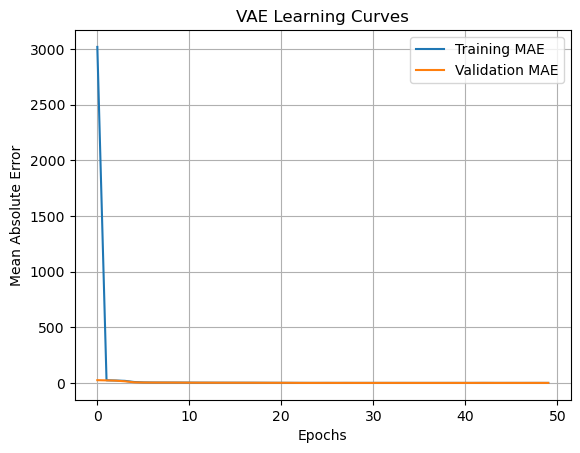

Mean: 0.4997236728668213
Logarithmic Variance: -3.9213128089904785


In [115]:
# Function to get max temperatures sequences
def get_max_temps(df, seq_length=84):
    max_temp = df['Mean maximum temperature (°C)'].values
    sequences = []
    for i in range(len(max_temp) - seq_length):
        sequences.append(max_temp[i:i + seq_length])
    sequences = np.array(sequences)
    return sequences

# Define a customised layer
class Sampling(tf.keras.Layer):
    def call(self, inputs):
        mean, logvar = inputs
        # Define the latent loss and add it to the loss function
        latent_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.exp(logvar) - tf.square(mean), axis=-1) / 784.
        self.add_loss(latent_loss)
        return tf.random.normal(tf.shape(logvar)) * tf.exp(logvar / 2) + mean

# Variational Autoencoder (VAE) model
def create_vae(input_shape, codings_size):
    # Encoder part of the VAE
    inputs = layers.Input(shape=input_shape)
    # Z = layers.Flatten()(inputs)
    Z = layers.Dense(150, activation="relu")(inputs)
    Z = layers.Dense(100, activation="relu")(Z)
    codings_mean = layers.Dense(codings_size)(Z) # mu
    codings_log_var = layers.Dense(codings_size)(Z) # gamma
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(inputs=inputs, outputs=[codings_mean, codings_log_var, codings])

    # Decoder part of the VAE
    decoder_inputs = tf.keras.Input(shape=[codings_size])
    x = layers.Dense(150, activation="relu")(decoder_inputs)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(84)(x)
    outputs = layers.Reshape(input_shape)(x)
    variational_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=outputs)

    # Join encoder and decoder together to form VAE
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae = tf.keras.Model(inputs=inputs, outputs=reconstructions)

    return variational_ae, variational_encoder, variational_decoder

# Get the max temperature sequences
X_train = get_max_temps(PerthA_df)
X_valid = get_max_temps(PerthM_val)

# Create the VAE model
codings_size = 8
vae, vae_encoder, vae_decoder = create_vae(input_shape=(84,), codings_size=codings_size)

# Train the VAE model
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
vae.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
history = vae.fit(X_train, X_train, validation_data=(X_valid, X_valid), epochs=50, batch_size=32, verbose=1)
plot_learning_curves(history, "VAE")

# Report the mean and logarithmic variance of the learned distribution
mean = vae_encoder(X_train)[0]
logvar = vae_encoder(X_train)[1]
mean = tf.reduce_mean(mean)
logvar = tf.reduce_mean(logvar)
print(f"Mean: {mean.numpy()}")
print(f"Logarithmic Variance: {logvar.numpy()}")

## Synthesise temperature sequences

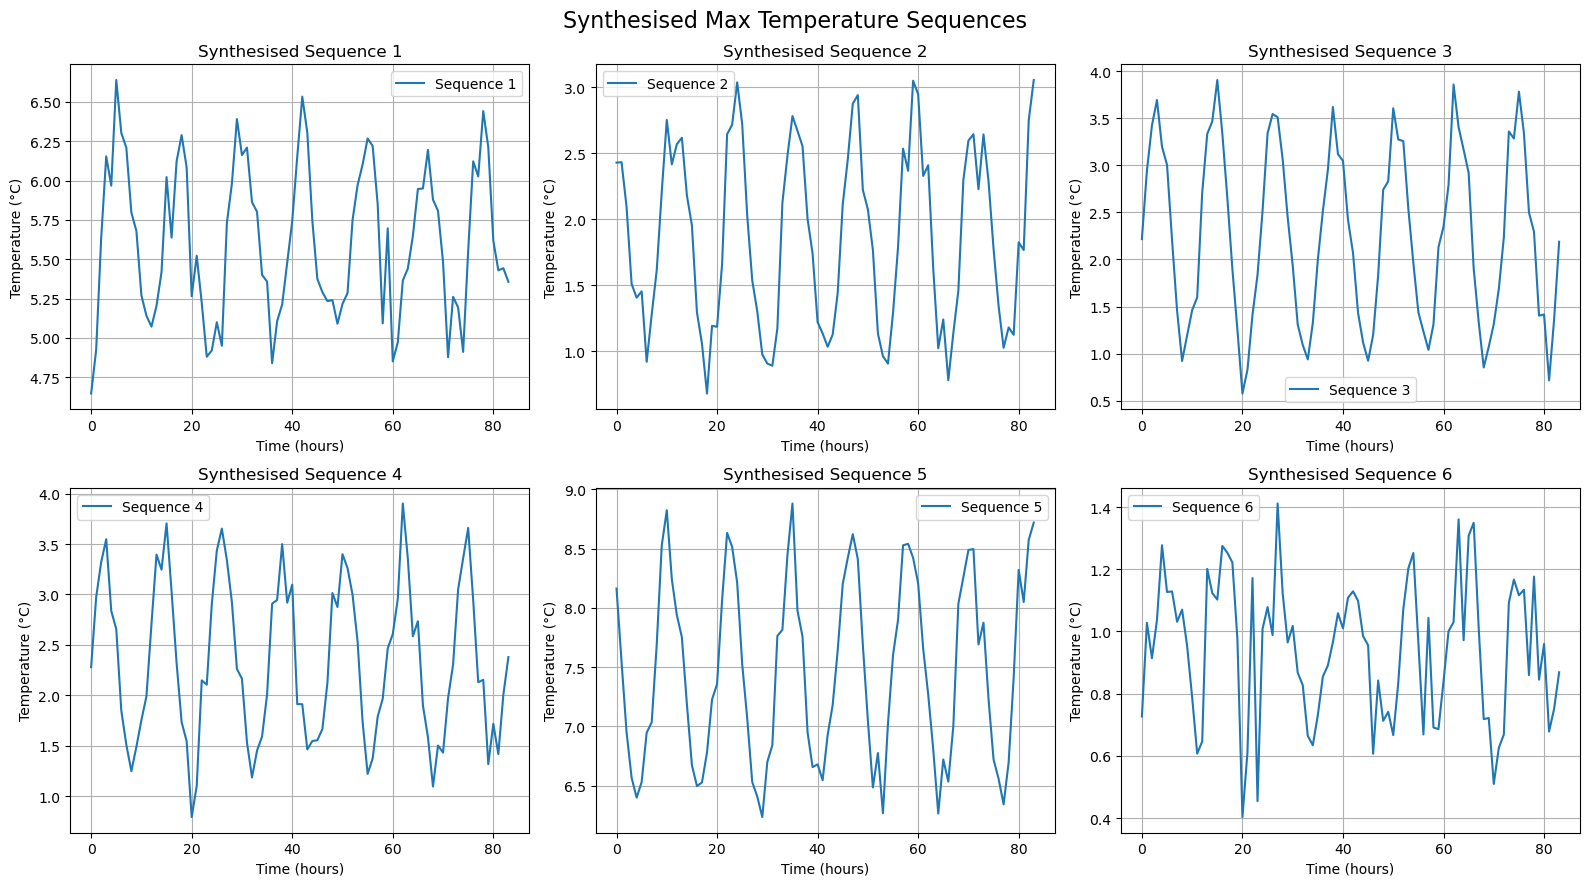

In [122]:
# Function to plot the synthesised sequences
def plot_synthesised_sequences(sequences, num_cols=3):
    num_rows = len(sequences) // num_cols + (len(sequences) % num_cols > 0)
    plt.figure(figsize=(16, 9))
    
    for i, seq in enumerate(sequences):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.plot(seq, label=f'Sequence {i + 1}')
        plt.title(f'Synthesised Sequence {i + 1}')
        plt.xlabel('Time (hours)')
        plt.ylabel('Temperature (°C)')
        plt.suptitle('Synthesised Max Temperature Sequences', fontsize=16)
        plt.grid()
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate synthetic max temperature sequences
num_samples = 6
codings = tf.random.normal(shape=(num_samples, codings_size))
synthetic_max_temps = vae_decoder.predict(codings, verbose=0)
plot_synthesised_sequences(synthetic_max_temps)